In [1]:
from hyperspace.kepler.data_utils import load_results
from hyperspace.kepler.plots import plot_convergence
from hyperparameter import objective
import pathlib
from os.path import join

env_name = 'AbstractConveyor1'

path = pathlib.Path().absolute()
path_ = join(path, 'rl', 'hyper_parameter','old', env_name, 'stochastic')
results = load_results(path_, sort=True)

INFO:tensorflow:TensorFlow


INFO:tensorflow:TensorFlow


AttributeError: 'tuple' object has no attribute 'figsize'

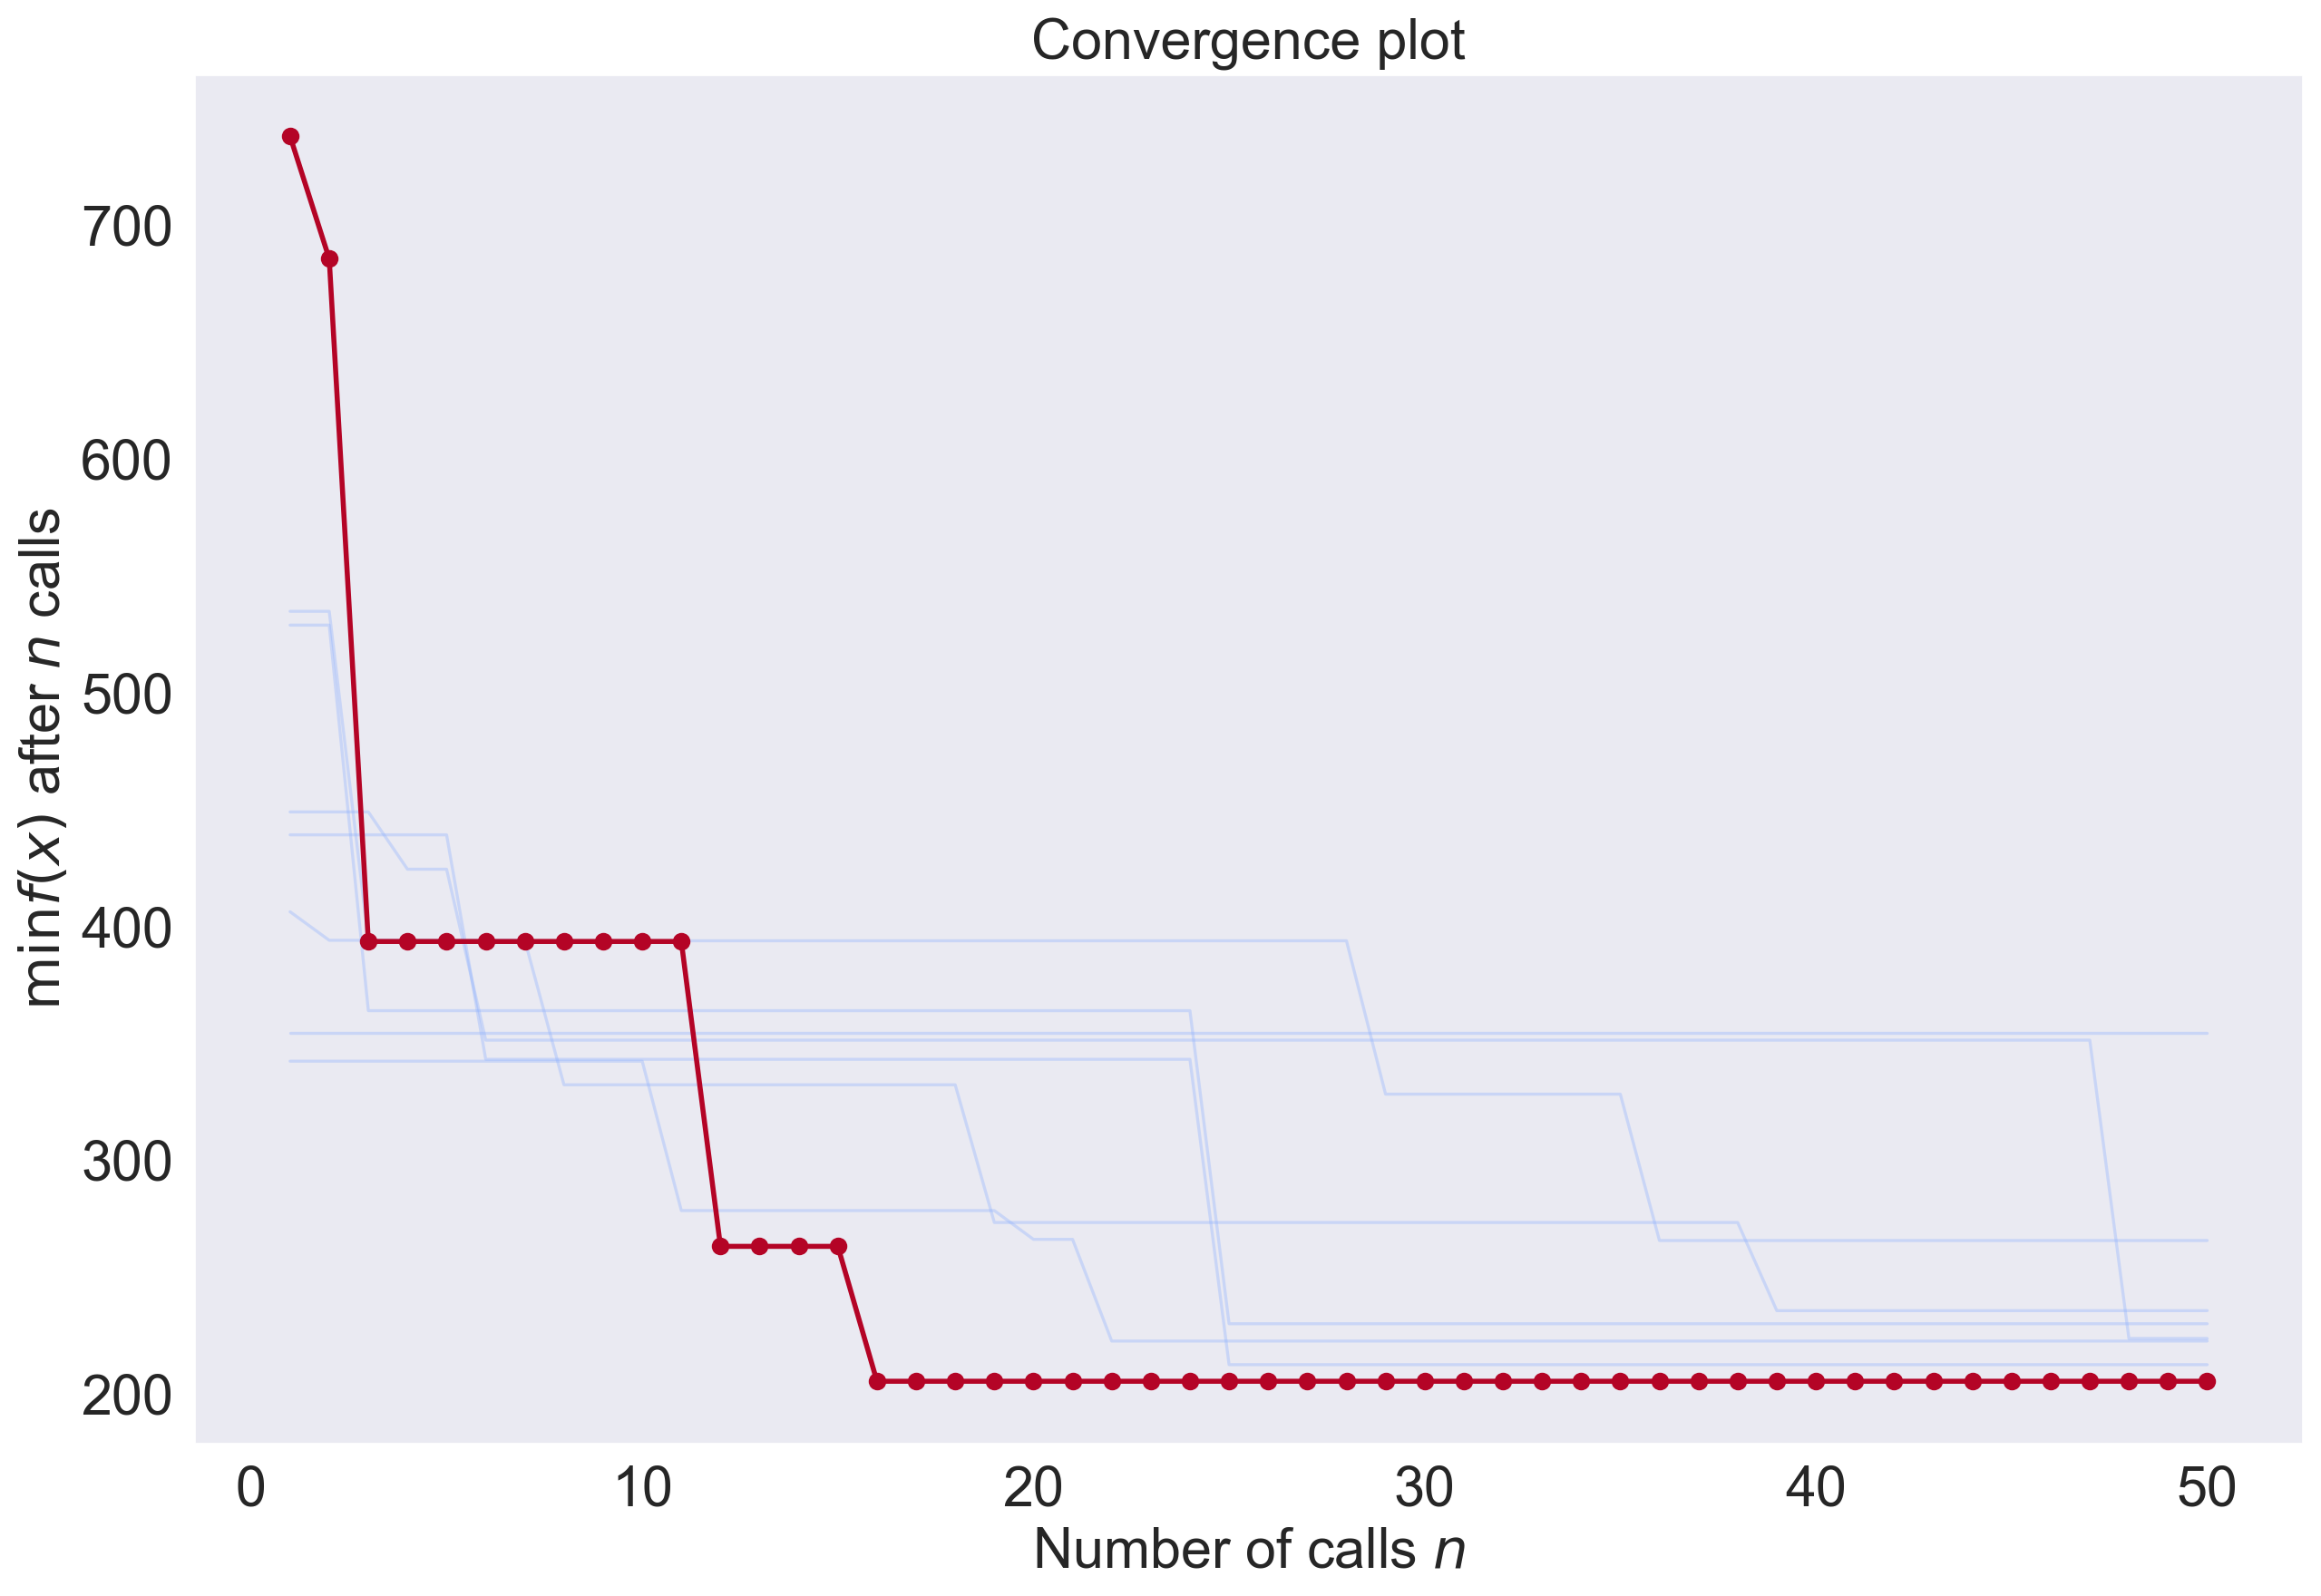

In [11]:
# for interpretations:
# https://hyperspace.readthedocs.io/en/latest/results.html
#best_result = results.pop(0)
_ = plot_convergence(results, results[0])

In [9]:
_

AttributeError: 'tuple' object has no attribute 'figsize'

In [3]:
print('Minimum {} at parameters:  \n'.format(results[0].fun))
t1, t2, t3, t4, t5, t6 = results[0].x
print('positive_reward_for_divert: \t\t   {} \n\
wrong_sup_at_goal:              \t   {} \n\
flooding_reward:                \t   {} \n\
neg_reward_ia:                  \t   {} \n\
negative_reward_for_empty_queue: \t   {} \n\
negative_reward_for_cycle:      \t   {} \n'.format(t1,t2,t3,t4,t5,t6) )

Minimum 205.3 at parameters:  

positive_reward_for_divert: 		   10 
wrong_sup_at_goal:              	   0 
flooding_reward:                	   9 
neg_reward_ia:                  	   15 
negative_reward_for_empty_queue: 	   15 
negative_reward_for_cycle:      	   6 



In [12]:
results[1].x

[15, 6, 6, 15, 9, 6]

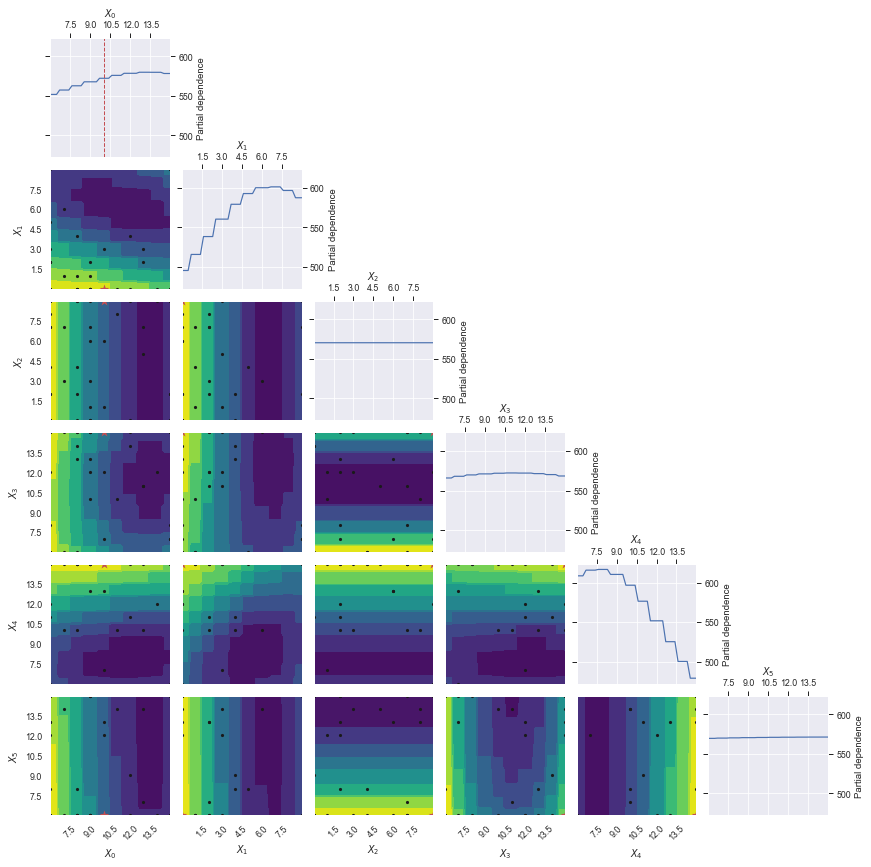

In [5]:
# for interpretations:
# https://hyperspace.readthedocs.io/en/latest/results.html
from skopt.plots import plot_objective
_ = plot_objective(results[0])

In [48]:
results[2].x

[7, 0, 5, 13, 11, 8]

In [11]:
from hyperspace.kepler.data_utils import load_results
from hyperspace.kepler.plots import plot_convergence
from hyperparameter1 import objective
import pathlib
from os.path import join

env_name = 'AbstractConveyor'

path = pathlib.Path().absolute()
path_ = join(path, 'rl', 'hyper_parameter1', env_name)
results = load_results(path_, sort=True)

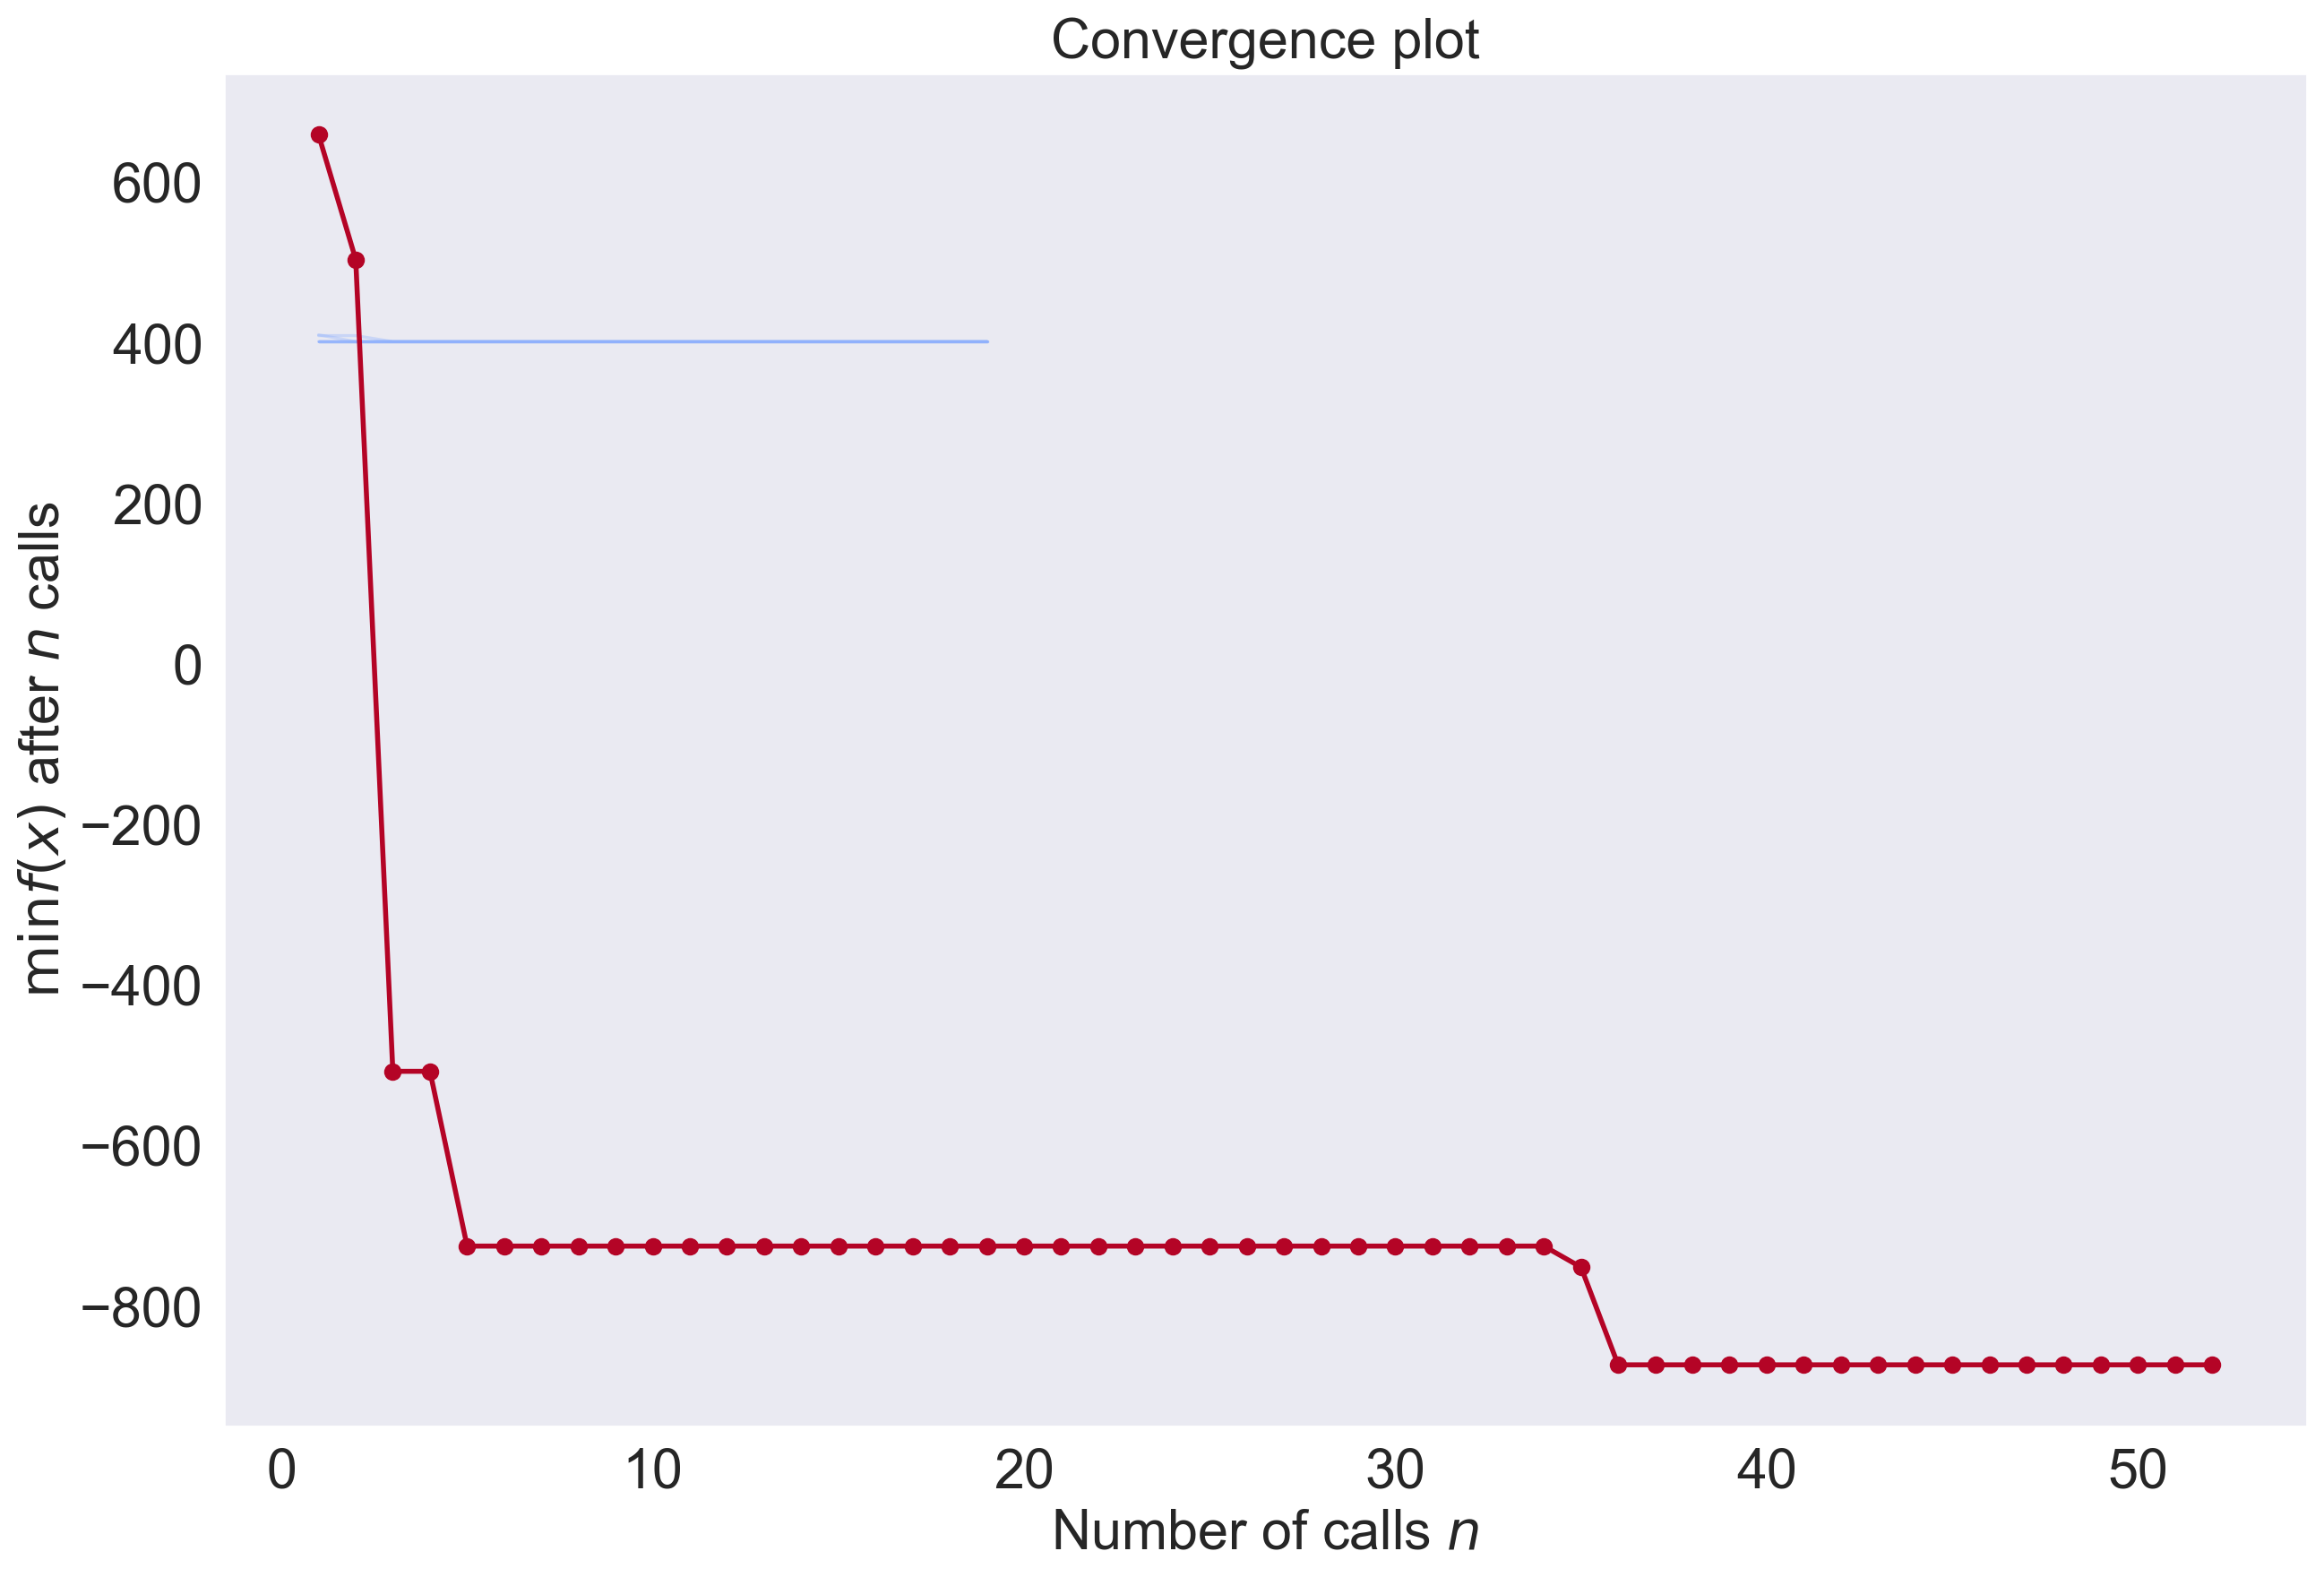

In [12]:
# for interpretations:
# https://hyperspace.readthedocs.io/en/latest/results.html
best_result = results.pop(0)
_ = plot_convergence(results, best_result)

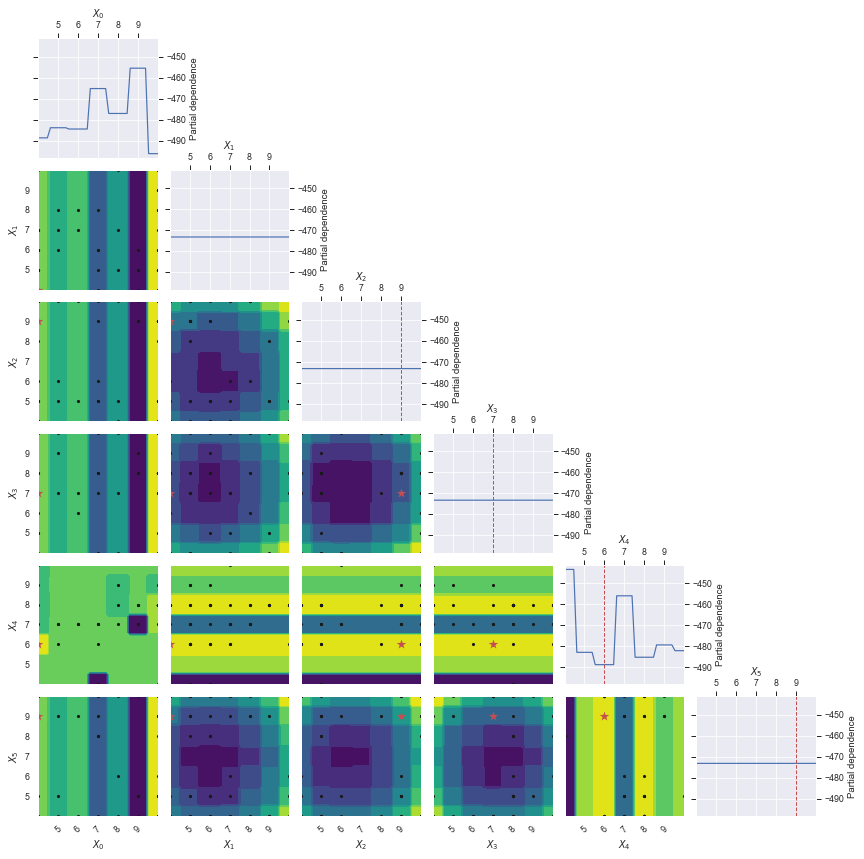

In [13]:
# for interpretations:
# https://hyperspace.readthedocs.io/en/latest/results.html
from skopt.plots import plot_objective
_ = plot_objective(best_result)

In [14]:
best_result.x

[4, 4, 9, 7, 6, 9]

In [ ]:
[7, 6, 1, 8, 4, 8]

In [13]:
import numpy as np
import pathlib
from os.path import join, isfile
from hyperspace import hyperdrive
from stable_baselines.common import make_vec_env
from stable_baselines import PPO2
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common.vec_env import DummyVecEnv
import datetime
import os
import yaml
import rl

env_name = 'AbstractConveyor'


path = pathlib.Path().absolute()


def objective(params):
    """
    Objective function to be minimized.

    Parameters
    ----------
    * params [list, len(params)=n_hyperparameters]
        Settings of each hyperparameter for a given optimization iteration.
        - Controlled by hyperspaces's hyperdrive function.
        - Order preserved from list passed to hyperdrive's hyperparameters argument.
     """
    config_path = join(path, 'rl', 'config', '{}.yml'.format(env_name))
    with open(config_path) as f:
        config = yaml.safe_load(f)
        print('model loaded from path: {}'.format(config_path))
    
    #set the parameters
    itrf, ccrf, opr, dr = params
    config['environment']['idle_time_reward_factor'] = itrf
    config['environment']['cycle_count_reward_factor'] = ccrf
    config['environment']['output_priming_reward'] = opr /100
    config['environment']['delivery_reward'] = dr

    
    print('Current settings for the config: \n\nidle_time_reward_factor \t:\t{}\ncycle_count_reward_factor\t\t:\t{}\n\
output_priming_reward\t\t\t:\t{}\ndelivery_reward\t\t\t:\t{}\n'.format(itrf, ccrf, opr/100, dr))
    
    #GET MODEL CONFIG
    model_config = config['models']['PPO2']
    policy = config['main']['policy']
    n_workers = config['main']['n_workers']
    n_steps = config['main']['n_steps']
    n_eval = (n_steps / 8)/10
    
    # load environment with config variables
    env_obj = getattr(rl.environments, env_name)
    env = env_obj(config)
    
    # multiprocess environment
    env_8 = make_vec_env(lambda: env, n_envs=n_workers)
    
    #define folder and path
    now = datetime.datetime.now()
    folder ='{}{}{}_{}{}'.format(now.year, str(now.month).zfill(2), str(now.day).zfill(2), str(now.hour).zfill(2), str(now.minute).zfill(2))
    specified_path = join(path, 'rl', 'trained_models', env_name, 'hyper-parameter1', '{}-{}{}{}{}'.format(folder, itrf, ccrf, opr, dr))
    print('Results stored in: {}'.format(specified_path))
    
    # callback for evaluation
    eval_callback = EvalCallback(env, best_model_save_path=specified_path,
                                 log_path=specified_path, eval_freq=n_eval,
                                 n_eval_episodes=5, verbose=0,
                                 deterministic=False, render=False)

    model = PPO2(policy, env=env_8, tensorboard_log=specified_path, **model_config)
    
    #LEARN MODEL
    model.learn(total_timesteps=n_steps, tb_log_name='{}_{}_{}_{}'.format(itrf, ccrf, opr, dr),
                        callback=eval_callback)
    model_path = join(specified_path, 'model_{}_{}_{}_{}.zip'.format(itrf, ccrf, opr, dr))
    model.save(model_path)
    
    #test
    best_modelpath = join(specified_path, 'best_model.zip')
    test_model = PPO2.load(best_modelpath, env=DummyVecEnv([lambda: env]))
    
    #run test of the model
    episodes = 10
    results = {}
    results['cycle_count'] = 0
    results['idle_time'] = 0
    for episode in range(episodes):
        # Run an episode
        state = env.reset()
        done = False
        meta_data = []
        while not done:
            action, _ = test_model.predict(state, deterministic=False)
            state, reward, done, _ = env.step(action)
            if done:
                results['cycle_count'] += env.cycle_count
                results['idle_time'] += sum(env.idle_times_operator.values())
    
    return (results['cycle_count'] + results['idle_time']) /episodes
    
def main():
    #hparams = [(low, high),        #per var
    #           (low, high)]
    hparams = [(0, 10), #positive_reward_for_divert
               (0, 10), #wrong_sup_at_goal
               (0, 100), #flooding_reward
               (0, 10)] #negative_reward_for_cycle
    
    #define path for the results
    hyperdive_results = join(path, 'rl', 'hyper_parameter1', env_name)
    
    #make folder if not exist
    try:
        os.mkdir(hyperdive_results)
    except:
        pass
    
    #run the hyper drive optimization
    hyperdrive(objective=objective,
               hyperparameters=hparams,
               results_path=hyperdive_results,
               checkpoints_path=hyperdive_results,
               model="GP",
               n_iterations=50,
               verbose=True,
               random_state=42)

if __name__=='__main__':
     main()

Iteration No: 1 started. Evaluating function at random point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

idle_time_reward_factor 	:	9
cycle_count_reward_factor		:	5
output_priming_reward			:	0.86
delivery_reward			:	8

Results stored in: D:\Drive\git\RL\rl\trained_models\AbstractConveyor\hyper-parameter1\20201124_2128-95868


KeyboardInterrupt: 

In [16]:
import numpy as np
import pathlib
from os.path import join, isfile
from hyperspace import hyperdrive
from stable_baselines.common import make_vec_env
from stable_baselines import PPO2
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common.vec_env import DummyVecEnv
import datetime
import os
import yaml
import rl

env_name = 'AbstractConveyor'


path = pathlib.Path().absolute()
def objective(params):
    """
    Objective function to be minimized.

    Parameters
    ----------
    * params [list, len(params)=n_hyperparameters]
        Settings of each hyperparameter for a given optimization iteration.
        - Controlled by hyperspaces's hyperdrive function.
        - Order preserved from list passed to hyperdrive's hyperparameters argument.
     """
    config_path = join(path, 'rl', 'config', '{}.yml'.format(env_name))
    with open(config_path) as f:
        config = yaml.safe_load(f)
        print('model loaded from path: {}'.format(config_path))
    
    #set the parameters
    itrf, ccrf, opr, dr = params
    config['environment']['idle_time_reward_factor'] = itrf
    config['environment']['cycle_count_reward_factor'] = ccrf
    config['environment']['output_priming_reward'] = opr /100
    config['environment']['delivery_reward'] = dr

    
    print('Current settings for the config: \n\nidle_time_reward_factor \t:\t{}\ncycle_count_reward_factor\t\t:\t{}\n\
output_priming_reward\t\t\t:\t{}\ndelivery_reward\t\t\t:\t{}\n'.format(itrf, ccrf, opr/100, dr))
    
    #GET MODEL CONFIG
    model_config = config['models']['PPO2']
    policy = config['main']['policy']
    n_workers = config['main']['n_workers']
    n_steps = config['main']['n_steps']
    n_eval = (n_steps / 8)/10
    
    # load environment with config variables
    env_obj = getattr(rl.environments, env_name)
    env = env_obj(config)
    
    # multiprocess environment
    env_8 = make_vec_env(lambda: env, n_envs=n_workers)
    
    #define folder and path
    now = datetime.datetime.now()
    folder ='{}{}{}_{}{}'.format(now.year, str(now.month).zfill(2), str(now.day).zfill(2), str(now.hour).zfill(2), str(now.minute).zfill(2))
    specified_path = join(path, 'rl', 'trained_models', env_name, 'hyper-parameter1', '{}-{}{}{}{}'.format(folder, itrf, ccrf, opr, dr))
    print('Results stored in: {}'.format(specified_path))
    
    # callback for evaluation
    eval_callback = EvalCallback(env, best_model_save_path=specified_path,
                                 log_path=specified_path, eval_freq=n_eval,
                                 n_eval_episodes=5, verbose=0,
                                 deterministic=False, render=False)

    model = PPO2(policy, env=env_8, tensorboard_log=specified_path, **model_config)
    
    #LEARN MODEL
    model.learn(total_timesteps=n_steps, tb_log_name='{}_{}_{}_{}'.format(itrf, ccrf, opr, dr),
                        callback=eval_callback)
    model_path = join(specified_path, 'model_{}_{}_{}_{}.zip'.format(itrf, ccrf, opr, dr))
    model.save(model_path)
    
    #test
    best_modelpath = join(specified_path, 'best_model.zip')
    test_model = PPO2.load(best_modelpath, env=DummyVecEnv([lambda: env]))
    
    #run test of the model
    episodes = 10
    results = {}
    results['cycle_count'] = 0
    results['idle_time'] = 0
    for episode in range(episodes):
        # Run an episode
        state = env.reset()
        done = False
        meta_data = []
        while not done:
            action, _ = test_model.predict(state, deterministic=False)
            state, reward, done, _ = env.step(action)
            if done:
                results['cycle_count'] += env.cycle_count
                results['idle_time'] += sum(env.idle_times_operator.values())
    
    return (results['cycle_count'] + results['idle_time']) /episodes

In [17]:
import random
parameters = (random.randint(1,10),random.randint(1,10),random.randint(1,100),random.randint(1,10))
print(parameters)
obj_result = objective(parameters)

(4, 6, 78, 10)
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor.yml
Current settings for the config: 

idle_time_reward_factor 	:	4
cycle_count_reward_factor		:	6
output_priming_reward			:	0.78
delivery_reward			:	10

Results stored in: D:\Drive\git\RL\rl\trained_models\AbstractConveyor\hyper-parameter1\20201126_1156-467810


In [20]:
import numpy as np
import pathlib
from os.path import join, isfile
from hyperspace import hyperdrive
from stable_baselines.common import make_vec_env
from stable_baselines import PPO2
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common.vec_env import DummyVecEnv
import datetime
import os
import yaml
import rl

env_name = 'AbstractConveyor1'


path = pathlib.Path().absolute()


def objective(params):
    """
    Objective function to be minimized.

    Parameters
    ----------
    * params [list, len(params)=n_hyperparameters]
        Settings of each hyperparameter for a given optimization iteration.
        - Controlled by hyperspaces's hyperdrive function.
        - Order preserved from list passed to hyperdrive's hyperparameters argument.
     """
    config_path = join(path, 'rl', 'config', '{}.yml'.format(env_name))
    with open(config_path) as f:
        config = yaml.load(f)
        print('model loaded from path: {}'.format(config_path))
    
    #set the parameters
    prfd, wsag, fr, nria, nrfeq, nrfc = params
    config['environment']['positive_reward_for_divert'] = prfd
    config['environment']['wrong_sup_at_goal'] = wsag
    config['environment']['flooding_reward'] = fr
    config['environment']['neg_reward_ia'] = nria
    config['environment']['negative_reward_for_empty_queue'] = nrfeq
    config['environment']['negative_reward_for_cycle'] = nrfc
    
    print('Current settings for the config: \n\npositive_reward_for_divert \t:\t{}\nwrong_sup_at_goal\t\t:\t{}\n\
flooding_reward\t\t\t:\t{}\nneg_reward_ia\t\t\t:\t{}\nnegative_reward_for_empty_queue\t:\t{}\n\
negative_reward_for_cycle\t:\t{}\n'.format(prfd, wsag, fr, nria, nrfeq, nrfc))
    
    #GET MODEL CONFIG
    model_config = config['models']['PPO2']
    policy = config['main']['policy']
    n_workers = config['main']['n_workers']
    n_steps = config['main']['n_steps']
    n_eval = (n_steps / 8)/10
    
    # load environment with config variables
    env_obj = getattr(rl.environments, env_name)
    env = env_obj(config)
    
    # multiprocess environment
    env_8 = make_vec_env(lambda: env, n_envs=n_workers)
    
    #define folder and path
    now = datetime.datetime.now()
    folder ='{}{}{}_{}{}'.format(now.year, str(now.month).zfill(2), str(now.day).zfill(2), str(now.hour).zfill(2), str(now.minute).zfill(2))
    specified_path = join(path, 'rl', 'trained_models', env_name, 'hyper-parameter', '{}-{}{}{}{}{}{}'.format(folder, prfd, wsag, fr, nria, nrfeq, nrfc))
    print('Results stored in: {}'.format(specified_path))
    
    # callback for evaluation
    eval_callback = EvalCallback(env, best_model_save_path=specified_path,
                                 log_path=specified_path, eval_freq=n_eval,
                                 n_eval_episodes=5, verbose=0,
                                 deterministic=False, render=False)

    model = PPO2(policy, env=env_8, tensorboard_log=specified_path, **model_config)
    
    #LEARN MODEL
    model.learn(total_timesteps=n_steps, tb_log_name='{}_{}_{}_{}_{}_{}'.format(prfd, wsag, fr, nria, nrfeq, nrfc),
                        callback=eval_callback)
    model_path = join(specified_path, 'model_{}_{}_{}_{}_{}_{}.zip'.format(prfd, wsag, fr, nria, nrfeq, nrfc))
    model.save(model_path)
    
    #test
    best_modelpath = join(specified_path, 'best_model.zip')
    test_model = PPO2.load(best_modelpath, env=DummyVecEnv([lambda: env]))
    
    #run test of the model
    episodes = 10
    results = {}
    results['cycle_count'] = 0
    results['idle_time'] = 0
    for episode in range(episodes):
        # Run an episode
        state = env.reset()
        done = False
        meta_data = []
        while not done:
            action, _ = test_model.predict(state, deterministic=False)
            state, reward, done, _ = env.step(action)
            if done:
                results['cycle_count'] += env.cycle_count
                results['idle_time'] += sum(env.idle_times_operator.values())
    
    return (results['cycle_count'] + results['idle_time']) /episodes
    
def main():
    #hparams = [(low, high),        #per var
    #           (low, high)]
    hparams = [(0, 15), #positive_reward_for_divert
               (0, 15), #wrong_sup_at_goal
               (0, 15), #flooding_reward
               (0, 15), #neg_reward_ia
               (0, 15), #negative_reward_for_empty_queue
               (0, 15)] #negative_reward_for_cycle
    
    #define path for the results
    hyperdive_results = join(path, 'rl', 'hyper_parameter', env_name)
    
    #make folder if not exist
    try:
        os.mkdir(hyperdive_results)
    except:
        pass
    
    #run the hyper drive optimization
    hyperdrive(objective=objective,
               hyperparameters=hparams,
               results_path=hyperdive_results,
               checkpoints_path=hyperdive_results,
               model="GP",
               n_iterations=50,
               verbose=True,
               random_state=42)

if __name__=='__main__':
     main()

c:\users\_vinc\appdata\local\programs\python\python37\lib\site-packages\skopt\space\space.py:502: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.low) / self.log_base,
c:\users\_vinc\appdata\local\programs\python\python37\lib\site-packages\skopt\space\space.py:504: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.low) / self.log_base)
c:\users\_vinc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Iteration No: 1 started. Evaluating function at random point.
model loaded from path: D:\Drive\git\RL\rl\config\AbstractConveyor1.yml
Current settings for the config: 

positive_reward_for_divert 	:	13
wrong_sup_at_goal		:	8
flooding_reward			:	13
neg_reward_ia			:	11
negative_reward_for_empty_queue	:	10
negative_reward_for_cycle	:	7

Results stored in: D:\Drive\git\RL\rl\trained_models\AbstractConveyor1\hyper-parameter\20201126_1358-1381311107


D:\Drive\git\RL\rl\environments\AbstractConveyor1.py:404: RuntimeWarning: invalid value encountered in long_scalars
  info.append(0)


KeyboardInterrupt: 